<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 4.1.1 Linear Regression

## Prediction of House Price Using Linear Regression

### Data

The Sacramento real estate transactions file is a list of 985 real estate transactions in the Sacramento area reported over a five-day period, as reported by the Sacramento Bee.

In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt

sns.set_context("poster")
sns.set(rc={'figure.figsize': (14, 8)})
sns.set_style("whitegrid")
sns.set(color_codes = True)

%matplotlib inline

### 1. Explore Data

Perform EDA on this dataset. Use what you have learned so far. Be creative. List all your findings.

In [4]:
# Read CSV
house_csv = pd.read_csv("dat/Sacramento_transactions.csv")

In [5]:
house_csv.describe()

,zip,beds,baths,sq__ft,price,latitude,longitude
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,95750.697462,2.911675,1.776650,1314.916751,234144.263959,38.607732,-121.355982
std,85.176072,1.307932,0.895371,853.048243,138365.839085,0.145433,0.138278
min,95603.000000,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,95660.000000,2.000000,1.000000,952.000000,145000.000000,38.482717,-121.446127
50%,95762.000000,3.000000,2.000000,1304.000000,213750.000000,38.626582,-121.376220
75%,95828.000000,4.000000,2.000000,1718.000000,300000.000000,38.695589,-121.295778
max,95864.000000,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


In [6]:
house_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


In [8]:
house_csv.shape

(985, 12)

In [9]:
house_csv.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [11]:
# Check Null Values
house_csv.isnull().sum()

street       0
city         0
zip          0
state        0
beds         0
baths        0
sq__ft       0
type         0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

In [13]:
house_csv.duplicated().sum()

3

In [15]:
house_csv['type'].value_counts()

Residential     917
Condo            54
Multi-Family     13
Unkown            1
Name: type, dtype: int64

In [19]:
house_csv['beds'].value_counts()

3    413
4    258
2    133
0    108
5     59
1     10
6      3
8      1
Name: beds, dtype: int64

In [21]:
house_csv['sq__ft'].value_counts()

0       171
1120      8
795       6
1410      5
1039      5
       ... 
1376      1
1375      1
1373      1
1371      1
2824      1
Name: sq__ft, Length: 603, dtype: int64

In [23]:
house_csv_subset = house_csv[house_csv['sq__ft'] != 0]

In [24]:
house_csv_subset.describe()

,zip,beds,baths,sq__ft,price,latitude,longitude
count,814.0000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000
mean,95761.4914,3.244472,1.960688,1591.146192,229448.369779,38.577044,-121.378687
std,85.3440,0.852137,0.669804,663.841930,119825.576060,0.126315,0.119736
min,95603.0000,1.000000,1.000000,484.000000,2000.000000,38.241514,-121.550527
25%,95670.0000,3.000000,2.000000,1144.000000,148750.000000,38.473885,-121.451501
50%,95820.0000,3.000000,2.000000,1418.500000,207986.500000,38.591720,-121.405456
75%,95828.0000,4.000000,2.000000,1851.000000,284973.250000,38.674704,-121.325844
max,95864.0000,8.000000,5.000000,5822.000000,884790.000000,39.008159,-120.597599


### 2. Predict Price

We are going to predict `price` from available information.

#### 2.1 What is the Target Variable? Why?

In [25]:
# ANSWER
y = house_csv_subset['price']
# we want to predict the price

#### 2.2 List all possible variables which might be Predictor variable.

In [26]:
# ANSWER
X = house_csv_subset['beds']

#### 2.3 Find correlation between variables

Find correlation between variables. Which is the best predictor? Why? State your reason.

In [27]:
# ANSWER
house_csv_subset.corr()
#sq_ft has the hightest corr with beds and baths and price

,zip,beds,baths,sq__ft,price,latitude,longitude
zip,1.000000,-0.072673,-0.103332,-0.101560,-0.219591,-0.134134,-0.562983
beds,-0.072673,1.000000,0.654746,0.695710,0.441988,-0.107440,0.056713
baths,-0.103332,0.654746,1.000000,0.724631,0.501820,-0.081249,0.108081
sq__ft,-0.101560,0.695710,0.724631,1.000000,0.693708,-0.103287,0.135809
price,-0.219591,0.441988,0.501820,0.693708,1.000000,0.058475,0.278312
latitude,-0.134134,-0.107440,-0.081249,-0.103287,0.058475,1.000000,0.344431
longitude,-0.562983,0.056713,0.108081,0.135809,0.278312,0.344431,1.000000


#### 2.4 What is the simplest way to predict price

So we have information for 985 houses. What is the easiest way to predict price of a house?

In [29]:
# ANSWER
house_csv_subset['avg_price'] = house_csv_subset['price'].mean()

<ipython-input-29-b379ebe17cc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_csv_subset['avg_price'] = house_csv_subset['price'].mean()


In [35]:
X = house_csv_subset['sq__ft']
y = house_csv_subset['price']
Yhat = house_csv_subset['avg_price']

In [36]:
def draw_plot(X, y, Yhat):
    ### Plot the data
    # create a figure
    fig = plt.figure(figsize=(15,7))
    # get the axis of that figure
    ax = plt.gca()

    # plot a scatter plot on it with our data
    ax.scatter(X, y, c='b')
    ax.plot(X, Yhat, color='r');

    plt.show();

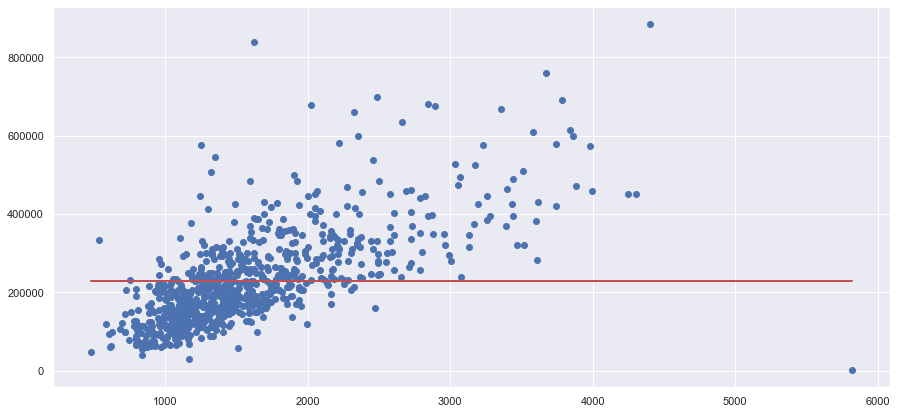

In [38]:
draw_plot(X, y, Yhat)

#### 2.5 Find Resudals

Find difference between actual value and predicted value. Use absolute value.

In [40]:
# ANSWER
res = abs(house_csv_subset['price'] - house_csv_subset['avg_price']).mean()
res

88232.20396742529

#### 2.6  Predict Using Linear Regression

[Simple Linear Regression](https://en.wikipedia.org/wiki/Simple_linear_regression#Fitting_the_regression_line)

### $$\hat{y} = \beta_0 + \beta_1 x$$

> ### $$ \beta_1 = \frac{\sum_{i=1}^n (y_i - \bar{y} ) (x_i - \bar{x} )}{\sum_{i=1}^n (x_i - \bar{x})^2} $$

and

> ### $$ \beta_0 = \bar{y} - \beta_1\bar{x} $$

Given variables:
- $\bar{y}$ : the sample mean of observed values $Y$
- $\bar{x}$ : the sample mean of observed values $X$

##### 2.7 Define X, Y

- X = Predictor Variable 
- Y = Target Variable

In [41]:
# ANSWER
X = house_csv_subset['sq__ft']
y = house_csv_subset['price']

##### 2.7.A Calculate beta_1

 ### $$ \beta_1 = \frac{\sum_{i=1}^n (y_i - \bar{y} ) (x_i - \bar{x} )}{\sum_{i=1}^n (x_i - \bar{x})^2} $$

In [42]:
# ANSWER
def calculate_beta_1(X, y):
    Xbar = X.mean()
    Ybar = y.mean()
    
    n = np.sum((y - Ybar) * (X - Xbar)) 
    d = np.sum(np.square(X - Xbar)) 
    
    beta_1 = n/d
    
    return beta_1

In [43]:
beta_1 = calculate_beta_1(X, y)
beta_1

125.21648667984462

##### 2.7.B Calculate beta_0

### $$ \beta_0 = \bar{y} - \beta_1\bar{x} $$

In [44]:
# ANSWER
def calculate_beta_0(X, y):
    
    Xbar = X.mean()
    Ybar = y.mean()
    
    beta_0 = Ybar - calculate_beta_1(X, y) * Xbar
    
    return beta_0

In [45]:
beta_0 = calculate_beta_0(X, y)
beta_0

30210.633866918943

##### 2.7.C Find Yhat (Predicted Value Using Beta 0 and Beta 1)

### $$\hat{y} = \beta_0 + \beta_1 x$$

In [46]:
# ANSWER
def calculate_yhat(x, b0, b1):
    return b0 + b1 * x

In [47]:
Yhat = calculate_yhat(X, beta_0, beta_1)
Yhat

0      134891.616731
1      176338.273822
2      129882.957264
3      136895.080518
4      130008.173751
           ...      
980    315704.223497
981    215155.384693
982    182473.881670
983    241200.413922
984    200755.488725
Name: sq__ft, Length: 814, dtype: float64

##### 2.7.D Find Residuals

### $$ \text{residual}_i = y_i - \hat{y}_i$$

In [48]:
# ANSWER
def calculate_residual(y, Yhat):
    res = y - Yhat
    return res

In [49]:
resi = calculate_residual(y, Yhat)
abs(resi)

0       75669.616731
1      108126.273822
2       61002.957264
3       67588.080518
4       48108.173751
           ...      
980     83279.223497
981     18844.615307
982     52526.118330
983      5899.413922
984     34982.511275
Length: 814, dtype: float64

##### 2.7.E Find R-Square

The coefficient $R^2$ is defined as $$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$, where $$ SS_{res} $$ is the residual sum of squares $$ SS_{res} = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 $$ and $$ SS_{res} $$ is the total sum of squares $$ SS_{tot} = \sum_{i=1}^n \left(y_i - \bar{y}\right)^2 $$

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

**Write a function to calculate R- Square value.**

The total sum of squares:

### $$ SS_{tot} = \sum_{i=1}^n \left(y_i - \bar{y}\right)^2 $$

The residual sum of squares:

### $$ SS_{res} = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 $$

$R^2$:

### $$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

In [50]:
# ANSWER
def calculate_total_sum_of_square(y):
    Ybar = np.mean(y)
    SStot = np.square(y - Ybar)
    SStot = np.sum(SStot)
    return SStot

In [51]:
def calculate_residual_sum_of_square(y, Yhat):
    SSres = np.square(y - Yhat)
    SSres = np.sum(SSres)
    return SSres

In [52]:
def calculate_r_square(y, Yhat):
    SStot = calculate_total_sum_of_square(y)
    SSres = calculate_residual_sum_of_square(y, Yhat)
    Rsquare = 1 - (SSres/SStot)
    return Rsquare

In [55]:
calculate_r_square(y, np.mean(y))

0.0

In [56]:
calculate_r_square(y, calculate_yhat(X, beta_0, beta_1))

0.4812307133326901

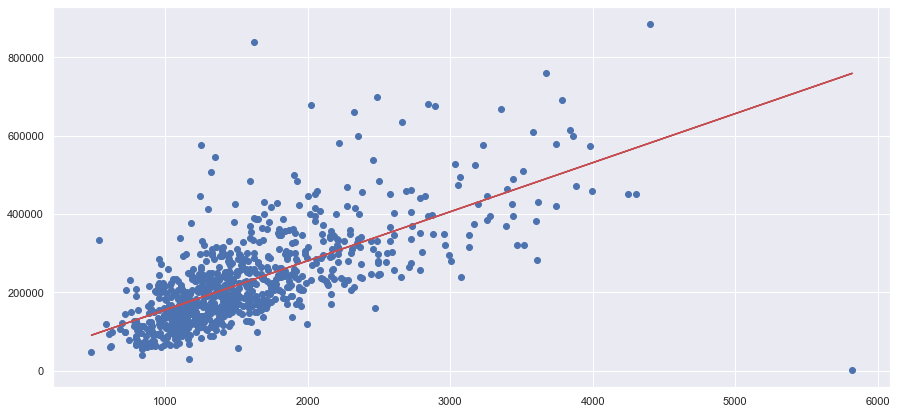

In [57]:
draw_plot(X, y, Yhat)

##### 2.7.F [BONUS] Draw Plot of Predicted Line and the datapoints

In [59]:
# ANSWER
house_csv['Yhat'] = Yhat

##### 2.7.G [BONUS] Draw Plot of Predicted Line With Residuals

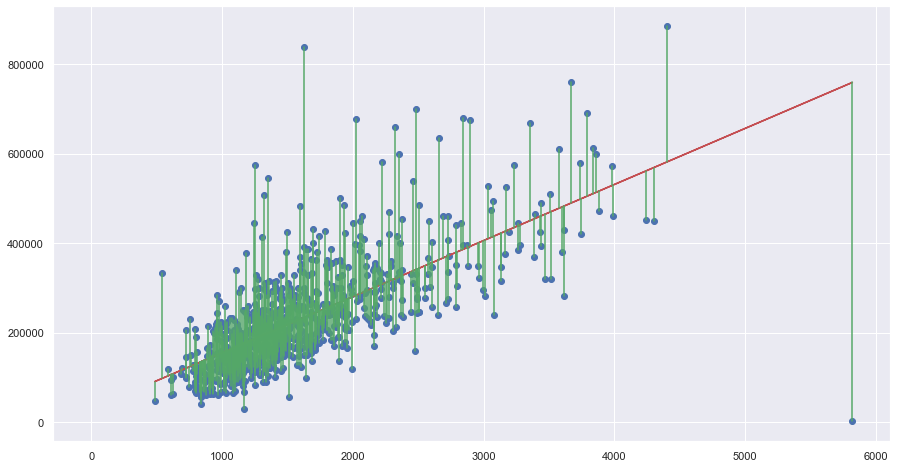

In [61]:
# ANSWER
# create a figure
fig = plt.figure(figsize=(15,7))
fig.set_figheight(8)
fig.set_figwidth(15)

# get the axis
ax = fig.gca()

# plot it
ax.scatter(x=X, y=y, c='b')
ax.plot(X, Yhat, color='r');

# iterate over predictions
for _, row in house_csv.iterrows():
    plt.plot((row['sq__ft'], row['sq__ft']), (row['price'], row['Yhat']), 'g-')

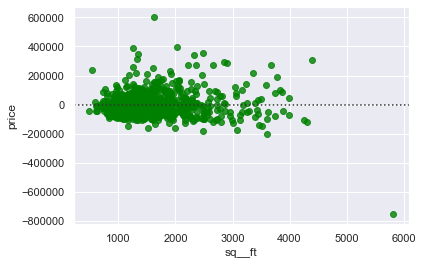

In [62]:
sns.residplot(x='sq__ft', y='price', data=house_csv_subset, color='green')
plt.show()

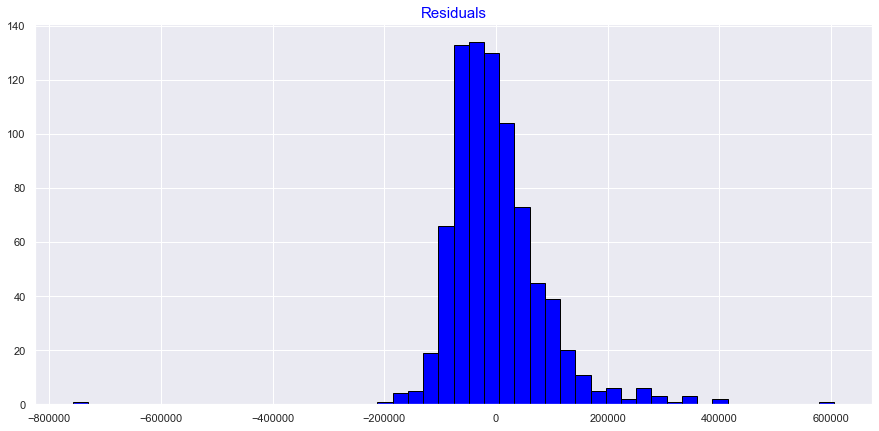

In [63]:
fig = plt.figure(figsize=(15,7))
n, bins, patches = plt.hist(resi, bins = 50, color='blue', edgecolor = 'black')
plt.title('Residuals', color = 'blue', fontsize=15)
plt.show()

### 3. Predict House Price

Let's assume we have information of following house:

- street:	1140 EDMONTON DR
- city:	SACRAMENTO
- zip:	95833
- state:	CA
- beds:	3
- baths:	2
- sq__ft:	1204
- type:	Residential

**Predict the price of this house.**

In [64]:
# ANSWER
xpred = 1204
xpred

1204

In [65]:
beta_0

30210.633866918943

In [66]:
beta_1

125.21648667984462

In [67]:
Ypred = beta_1 * xpred + beta_0
Ypred

180971.28382945186



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



